In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from seaborn import heatmap
from fancyimpute import IterativeImputer
from random import randint

# Прогноз данных об одобрении кредита

Заказщик - финансовая организация, выдающая все виды кредитов. Нужно понять какие факторы влияют на платежеспособность клиента.

**Цели исследования:**
1) Влияет ли возрат на вероятность возврата кредита в срок?
2) Влияет ли семейное положение на вероятность возврата кредита в срок?
3) Влияет ли зарплата на вероятность возврата кредита в срок?
4) Влияет ли наличие образования на вероятность возврата кредита в срок?

**Ход исследования:**

Входные данные от банка — статистика о платёжеспособности клиентов — получены из файла data.csv. О качестве данных ничего не известно. Поэтому перед тем, как отвечать на вопрсоы исследования и делать вывод, понадобится обзор данных.
Проверим данные на ошибки и оценим их влияние на исследование. Затем, на этапе предобработки, поищем возможность исправить самые критичные ошибки данных.

После ответа на поставленные в исследовании вопросы, сделаем общией вывод.

Таким образом, исследование пройдёт в четыре этапа:

1) Обзор данных
2) Предобработка данных
3) Ответы на вопросы исследования
4) Общий вывод

## Обзор данных

In [44]:
# try:
#     data = pd.read_csv('/datasets/data.csv')
# except:
#     data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')

# безопасней чиать файл так, но сначала нужно загрузить данные в облачное хранилище 

df = pd.read_csv('/home/angelina/Документы/ data_finance /train.csv')
df.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


Получим размер выборки

In [45]:
df.shape

(614, 13)

Получим основную информацию о дата сете

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [47]:
df.describe().applymap(lambda x: round(x, 2))

/tmp/ipykernel_12737/879548836.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.describe().applymap(lambda x: round(x, 2))


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.00,614.00,592.00,600.00,564.00
mean,5403.46,1621.25,146.41,342.00,0.84
std,6109.04,2926.25,85.59,65.12,0.36
min,150.00,0.00,9.00,12.00,0.00
25%,2877.50,0.00,100.00,360.00,1.00
50%,3812.50,1188.50,128.00,360.00,1.00
75%,5795.00,2297.25,168.00,360.00,1.00
max,81000.00,41667.00,700.00,480.00,1.00


## Предобработка данных

###  Удаление пропусков 

Посмотрим сколько пропусков в данных есть для каждого столбца

In [48]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [49]:
df[df.isnull().sum(axis=1) >= 3]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
95,LP001326,Male,No,0,Graduate,NaN,6782,0.0,NaN,360.0,NaN,Urban,N
435,LP002393,Female,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y


In [50]:
df['Education'].value_counts(), df['Married'].value_counts(), df['Self_Employed'].value_counts(), df['Loan_Status'].value_counts()

(Education
 Graduate        480
 Not Graduate    134
 Name: count, dtype: int64,
 Married
 Yes    398
 No     213
 Name: count, dtype: int64,
 Self_Employed
 No     500
 Yes     82
 Name: count, dtype: int64,
 Loan_Status
 Y    422
 N    192
 Name: count, dtype: int64)

Можно заметить, что 5 колонок с категориальными признаками имеют только два значения. Можем изменить на значения 0 и 1, чтоб можено было провести корреляционный анализ, с помощью heatmap

In [51]:
df['Married'] = df['Married'].map({'Yes': 1, 'No': 0, 'Y': 1, 'N': 0})
df['Loan_Status'] = df['Loan_Status'].map({'Yes': 1, 'No': 0, 'Y': 1, 'N': 0})
df['Education'] = df['Education'].map({'Graduate': 1, 'Not Graduate': 0})
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,0.0,0,1,No,5849,0.0,NaN,360.0,1.0,Urban,1
1,LP001003,Male,1.0,1,1,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,LP001005,Male,1.0,0,1,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,LP001006,Male,1.0,0,0,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,LP001008,Male,0.0,0,1,No,6000,0.0,141.0,360.0,1.0,Urban,1


Посмотрим корреляцию данных, наша задача найти зависимости стобцов:
* Dependents, 
* Self_Employed, 
* LoanAmount,
* Loan_Amount_Term, 
* Credit_History,

с другими данными. Смотим именно на эти столбцы, так как в них большое количество отсутствующих значений важных для исследования 

<Axes: >

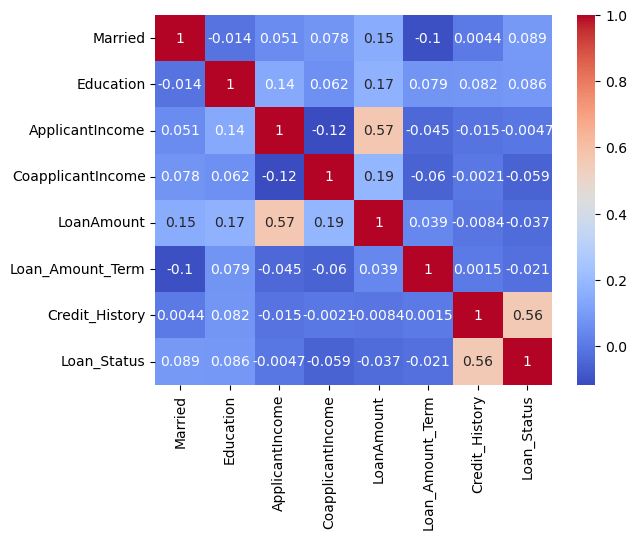

In [52]:
corr_df = df.corr(numeric_only=True)
heatmap(corr_df, annot=True, cmap='coolwarm')

Можно увидеть что сумма кредита зависит от зарплаты.
                  кредитная история зависит от  Можно заполнить пропуски в LoanAmount в зависимости от зарплаты клиента.  

Так как столбец LoadAmount линейно зависит от других столбцов можем использовать функцию MICE

In [53]:
df.loc[:, ['LoanAmount', 'Credit_History']] = IterativeImputer().fit_transform(df.loc[:, ['LoanAmount', 'Credit_History']])

In [54]:
df[df['Married'].isna()] = randint(0,1)

In [55]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               0
Dependents           12
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

во всех данных, которые были небходимы для исследования, заполнены отсутствующие значения

### Обработка дубликатов

In [56]:
df.duplicated().sum()

np.int64(2)

In [57]:
df = df.drop_duplicates()

 ### Обработка выбросов

In [58]:
df['LoanAmount'].min()

1.0